### Installing and importing libraries

In [6]:
!pip install hazm
!pip install pandas
!pip install numpy
!pip install nltk
!pip install tqdm

In [7]:
import pandas as pd
import numpy as np
from hazm import *
import tqdm
import json
import codecs
from nltk import FreqDist
import random
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn import metrics
import matplotlib.pyplot as plt
import pickle

### Import data

In [8]:
news_dict = {}
with open('../data/news.json', "r", encoding="utf-8") as text_file:
        news_dict = json.loads(text_file.read())

df = pd.DataFrame.from_dict(news_dict, orient='index')
df

,title,subject,content
0,هاشمی: هماهنگ کردم آزمون خبرگان را از حسن روحا...,سیاسی,به گزارش همشهری آنلاین، روزنامه فرهیختگان در ش...
1,اصلاح قانون اسلحه از کجا کلید خورد؟ ا مامور ...,سیاسی,همشهری‌آنلاین- امیرمحمدحسینی:اصلاحیه قانون به ...
2,ایران در برابر قطعنامه‌های آژانس سکوت نمی‌کند ...,سیاسی,به گزارش همشهری‌آنلاین،فدا حسین مالکی در مورد ...
3,اینفوگرافیک | اصلاحات قانون به‌کارگیری اسلحه چ...,سیاسی,ЩҮЩ…ШҙЩҮШұЫҢ ШўЩҶЩ„Ш§ЫҢЩҶ - Ш§Щ…ЫҢШұЩ…ШӯЩ…ШҜ Ш...
4,پیام تبریک رئیسی به رییس‌جمهور فیلیپین,سیاسی,به گزارش همشهری‌آنلاین، آیت‌الله سید ابراهیم ر...
...,...,...,...
14871,عکس | ۲ ستاره تیم ملی در میان برترین گلزنان مق...,ورزش,به گزارش همشهری آنلاین مسابقات مقدماتی جام جها...
14872,عکس| ۲۷ تیم راه یافته به جام جهانی | ۵ تیم باق...,ورزش,به گزارش همشهری آنلاین با صعود پرتغال و لهستان...
14873,عکس | برد پرگل برزیل در شب خداحافظی کلمبیا و ش...,ورزش,به گزارش همشهری آنلاین مسابقات مقدماتی جام جها...
14874,خداحافظی غم انگیز کی روش با تیم ملی مصر | رنج ...,ورزش,به گزارش همشهری آنلاین تیم ملی مصر در مصاف با ...


### Pre processing

In [9]:
normalizer = Normalizer()

normalized_news_dict = {}
for idx,value in tqdm.tqdm(news_dict.items()):
    normalized_news_dict[idx] = {"title" : value['title'] , "subject": value['subject'], "content":normalizer.normalize(value['content'])}
  
news_df = pd.DataFrame.from_dict(normalized_news_dict, orient='index')

100%|███████████████████████████████████| 14876/14876 [00:13<00:00, 1142.16it/s]


In [10]:
new_stopwords = [normalizer.normalize(x.strip()) for x in codecs.open('../custom_requirments/new_stopwords.txt','r','utf-8').readlines()]
stopwords = [normalizer.normalize(x.strip()) for x in codecs.open('../custom_requirments/stopwords.txt','r','utf-8').readlines()]

In [11]:
tokenized_words = [word_tokenize(_) for _ in news_df.content]

In [12]:
removed_tokenized_words = []
for per_content_words in tokenized_words:
  words = []
  for word in per_content_words:
    if word not in stopwords + new_stopwords:
      words.append(word)
  removed_tokenized_words.append(words)

news_df['word_tokenize'] = removed_tokenized_words
news_df

,title,subject,content,word_tokenize
0,هاشمی: هماهنگ کردم آزمون خبرگان را از حسن روحا...,سیاسی,به گزارش همشهری آنلاین، روزنامه فرهیختگان در ش...,"[گزارش, همشهری, آنلاین, روزنامه, فرهیختگان, شم..."
1,اصلاح قانون اسلحه از کجا کلید خورد؟ ا مامور ...,سیاسی,همشهری‌آنلاین- امیرمحمدحسینی: اصلاحیه قانون به...,"[همشهری‌آنلاین-, امیرمحمدحسینی, اصلاحیه, قانون..."
2,ایران در برابر قطعنامه‌های آژانس سکوت نمی‌کند ...,سیاسی,به گزارش همشهری‌آنلاین، فدا حسین مالکی در مورد...,"[گزارش, همشهری‌آنلاین, فدا, حسین, مالکی, قطعنا..."
3,اینفوگرافیک | اصلاحات قانون به‌کارگیری اسلحه چ...,سیاسی,ЩҮЩ…ШҙЩҮШұЫҢ ШўЩҶЩ„Ш§ЫҢЩҶ - Ш§Щ…ЫҢШұЩ…ШӯЩ…ШҜ Ш...,"[ЩҮЩ…ШҙЩҮШұЫҢ, ШўЩҶЩ„Ш§ЫҢЩҶ, Ш§Щ…ЫҢШұЩ…ШӯЩ…ШҜ,..."
4,پیام تبریک رئیسی به رییس‌جمهور فیلیپین,سیاسی,به گزارش همشهری‌آنلاین، آیت‌الله سید ابراهیم ر...,"[گزارش, همشهری‌آنلاین, آیت‌الله, سید, ابراهیم,..."
...,...,...,...,...
14871,عکس | ۲ ستاره تیم ملی در میان برترین گلزنان مق...,ورزش,به گزارش همشهری آنلاین مسابقات مقدماتی جام جها...,"[گزارش, همشهری, آنلاین, مسابقات, مقدماتی, جام,..."
14872,عکس| ۲۷ تیم راه یافته به جام جهانی | ۵ تیم باق...,ورزش,به گزارش همشهری آنلاین با صعود پرتغال و لهستان...,"[گزارش, همشهری, آنلاین, صعود, پرتغال, لهستان, ..."
14873,عکس | برد پرگل برزیل در شب خداحافظی کلمبیا و ش...,ورزش,به گزارش همشهری آنلاین مسابقات مقدماتی جام جها...,"[گزارش, همشهری, آنلاین, مسابقات, مقدماتی, جام,..."
14874,خداحافظی غم انگیز کی روش با تیم ملی مصر | رنج ...,ورزش,به گزارش همشهری آنلاین تیم ملی مصر در مصاف با ...,"[گزارش, همشهری, آنلاین, تیم, ملی, مصر, مصاف, س..."


In [13]:
stemmer = Stemmer()
lemmatizer = Lemmatizer()

def get_lemma_set(tok, opt=1):
    if opt == 1:
        return stemmer.stem(tok)
    if opt == 2:
        return lemmatizer.lemmatize(tok)

In [14]:
opt = 2
lemmatize_stemming_words = []
for per_content_words in news_df.word_tokenize:
  words = []
  for word in per_content_words:
    words.append(get_lemma_set(word,opt))
  lemmatize_stemming_words.append(words)
news_df['word_lemmatize'] = lemmatize_stemming_words
news_df

,title,subject,content,word_tokenize,word_lemmatize
0,هاشمی: هماهنگ کردم آزمون خبرگان را از حسن روحا...,سیاسی,به گزارش همشهری آنلاین، روزنامه فرهیختگان در ش...,"[گزارش, همشهری, آنلاین, روزنامه, فرهیختگان, شم...","[گزارش, همشهری, آنلاین, روزنامه, فرهیختگان, شم..."
1,اصلاح قانون اسلحه از کجا کلید خورد؟ ا مامور ...,سیاسی,همشهری‌آنلاین- امیرمحمدحسینی: اصلاحیه قانون به...,"[همشهری‌آنلاین-, امیرمحمدحسینی, اصلاحیه, قانون...","[همشهری‌آنلاین-, امیرمحمدحسینی, اصلاحیه, قانون..."
2,ایران در برابر قطعنامه‌های آژانس سکوت نمی‌کند ...,سیاسی,به گزارش همشهری‌آنلاین، فدا حسین مالکی در مورد...,"[گزارش, همشهری‌آنلاین, فدا, حسین, مالکی, قطعنا...","[گزارش, همشهری‌آنلاین, فدا, حسین, مالکی, قطعنا..."
3,اینفوگرافیک | اصلاحات قانون به‌کارگیری اسلحه چ...,سیاسی,ЩҮЩ…ШҙЩҮШұЫҢ ШўЩҶЩ„Ш§ЫҢЩҶ - Ш§Щ…ЫҢШұЩ…ШӯЩ…ШҜ Ш...,"[ЩҮЩ…ШҙЩҮШұЫҢ, ШўЩҶЩ„Ш§ЫҢЩҶ, Ш§Щ…ЫҢШұЩ…ШӯЩ…ШҜ,...","[ЩҮЩ…ШҙЩҮШұЫҢ, ШўЩҶЩ„Ш§ЫҢЩҶ, Ш§Щ…ЫҢШұЩ…ШӯЩ…ШҜ,..."
4,پیام تبریک رئیسی به رییس‌جمهور فیلیپین,سیاسی,به گزارش همشهری‌آنلاین، آیت‌الله سید ابراهیم ر...,"[گزارش, همشهری‌آنلاین, آیت‌الله, سید, ابراهیم,...","[گزارش, همشهری‌آنلاین, آیت‌الله, سید, ابراهیم,..."
...,...,...,...,...,...
14871,عکس | ۲ ستاره تیم ملی در میان برترین گلزنان مق...,ورزش,به گزارش همشهری آنلاین مسابقات مقدماتی جام جها...,"[گزارش, همشهری, آنلاین, مسابقات, مقدماتی, جام,...","[گزارش, همشهری, آنلاین, مسابقات, مقدمات, جام, ..."
14872,عکس| ۲۷ تیم راه یافته به جام جهانی | ۵ تیم باق...,ورزش,به گزارش همشهری آنلاین با صعود پرتغال و لهستان...,"[گزارش, همشهری, آنلاین, صعود, پرتغال, لهستان, ...","[گزارش, همشهری, آنلاین, صعود, پرتغال, لهستان, ..."
14873,عکس | برد پرگل برزیل در شب خداحافظی کلمبیا و ش...,ورزش,به گزارش همشهری آنلاین مسابقات مقدماتی جام جها...,"[گزارش, همشهری, آنلاین, مسابقات, مقدماتی, جام,...","[گزارش, همشهری, آنلاین, مسابقات, مقدمات, جام, ..."
14874,خداحافظی غم انگیز کی روش با تیم ملی مصر | رنج ...,ورزش,به گزارش همشهری آنلاین تیم ملی مصر در مصاف با ...,"[گزارش, همشهری, آنلاین, تیم, ملی, مصر, مصاف, س...","[گزارش, همشهری, آنلاین, تیم, ملی, مصر, مصاف, س..."


In [15]:
words = []
for row_words in news_df['word_lemmatize']:
  words.append(' '.join(row_words))
news_df['clean_text'] = words
news_df = news_df.drop(['word_tokenize','word_lemmatize'],axis=1)
news_df

,title,subject,content,clean_text
0,هاشمی: هماهنگ کردم آزمون خبرگان را از حسن روحا...,سیاسی,به گزارش همشهری آنلاین، روزنامه فرهیختگان در ش...,گزارش همشهری آنلاین روزنامه فرهیختگان شماره ام...
1,اصلاح قانون اسلحه از کجا کلید خورد؟ ا مامور ...,سیاسی,همشهری‌آنلاین- امیرمحمدحسینی: اصلاحیه قانون به...,همشهری‌آنلاین- امیرمحمدحسینی اصلاحیه قانون کار...
2,ایران در برابر قطعنامه‌های آژانس سکوت نمی‌کند ...,سیاسی,به گزارش همشهری‌آنلاین، فدا حسین مالکی در مورد...,گزارش همشهری‌آنلاین فدا حسین مالکی قطعنامه ضد ...
3,اینفوگرافیک | اصلاحات قانون به‌کارگیری اسلحه چ...,سیاسی,ЩҮЩ…ШҙЩҮШұЫҢ ШўЩҶЩ„Ш§ЫҢЩҶ - Ш§Щ…ЫҢШұЩ…ШӯЩ…ШҜ Ш...,ЩҮЩ…ШҙЩҮШұЫҢ ШўЩҶЩ„Ш§ЫҢЩҶ Ш§Щ…ЫҢШұЩ…ШӯЩ…ШҜ ШӯШ...
4,پیام تبریک رئیسی به رییس‌جمهور فیلیپین,سیاسی,به گزارش همشهری‌آنلاین، آیت‌الله سید ابراهیم ر...,گزارش همشهری‌آنلاین آیت‌الله سید ابراهیم رییس ...
...,...,...,...,...
14871,عکس | ۲ ستاره تیم ملی در میان برترین گلزنان مق...,ورزش,به گزارش همشهری آنلاین مسابقات مقدماتی جام جها...,گزارش همشهری آنلاین مسابقات مقدمات جام جهانی ۲...
14872,عکس| ۲۷ تیم راه یافته به جام جهانی | ۵ تیم باق...,ورزش,به گزارش همشهری آنلاین با صعود پرتغال و لهستان...,گزارش همشهری آنلاین صعود پرتغال لهستان ۵ تیم آ...
14873,عکس | برد پرگل برزیل در شب خداحافظی کلمبیا و ش...,ورزش,به گزارش همشهری آنلاین مسابقات مقدماتی جام جها...,گزارش همشهری آنلاین مسابقات مقدمات جام جهانی ۲...
14874,خداحافظی غم انگیز کی روش با تیم ملی مصر | رنج ...,ورزش,به گزارش همشهری آنلاین تیم ملی مصر در مصاف با ...,گزارش همشهری آنلاین تیم ملی مصر مصاف سنگال تسا...


## Clustering

In [25]:
def load_fasttext_embedding():
    with open('../models/clustering/fasttext/fasttext_vectors_emb.json', 'r', encoding="utf-8") as f:
        loaded_embedding = json.loads(f.read())
    return loaded_embedding

def prepare_documents_and_categories(df):
    final_dict = df.to_dict('index')
    target_category = df['subject'].unique()
    target_category = target_category.tolist()

    category_dictionary_reverted = dict(enumerate(target_category))
    category_dictionary = dict((v,k) for k,v in category_dictionary_reverted.items())
    
    return final_dict, category_dictionary

def prepare_train_test_data(categories, final_dict, embeddings):
    doc_num = {_:0 for _ in categories.values()}
    x_train = list()
    y_test = list()
    doc_titles = list()
    shuffeled_data = random.sample(sorted(final_dict) ,len(final_dict))

    for i in tqdm.tqdm(range(0, len(shuffeled_data))):
        doc = shuffeled_data[i]
        if final_dict[doc]['subject'] in categories:
            doc_num[categories[final_dict[doc]['subject']]] += 1
            y_test.append(categories[final_dict[doc]['subject']])
            x_train.append(embeddings[doc])
            doc_titles.append(final_dict[doc]['title'])
    return x_train, y_test, doc_titles

def fit_kmeans_clustering(x, n_clusters=11, n_init=50, max_iter=1000, tol=1e-8):
    return KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter, tol=tol).fit(x)

def save_kmeans_model(model):
    pickle.dump(model, open("../models/clustering/kmeans_clustering.pkl", "wb"))
    
def load_kmeans_model():
    return pickle.load(open("../models/clustering/kmeans_clustering.pkl", "rb"))

def predict_kmeans_model(model, x_train):
    y_pred = model.predict(x_train)
    return y_pred

def centroid_kmeans_model(model, y_pred):
    y_center = [model.cluster_centers_[y] for y in y_pred]
    return y_center

def print_clusters(y_pred):
    for i in range(0,11):
        print(f'cluster {i}\t:   {y_pred.tolist().count(i)}')
        
def samples_from_cluster(doc_titles, predicted_list, category_id, k=5):
    c = 0
    ls = []
    for predicted_category, doc_title in zip(predicted_list, doc_titles):
        if predicted_category == category_id:
            ls.append(doc_title)
            c += 1
        else:
            continue
        if c == k:
            break
    return ls

def evaluate_clustering(model, x_train, y_pred, y_test):
    print('-------------------------------------------')
    print(f'RSS = {model.inertia_}')
    print(f'Davies Bouldin score = {davies_bouldin_score(x_train, y_pred)}')
    print(f'Silhouette score = {metrics.silhouette_score(x_train, y_pred)}')
    contin_matrix = metrics.cluster.contingency_matrix(y_test, y_pred)
    purity_score = np.sum(np.amax(contin_matrix, axis=0)) / np.sum(contin_matrix)
    print(f'Purity score = {purity_score}')

In [26]:
loaded_docs_embs_ft = load_fasttext_embedding()
final_news_dict, category_dictionary = prepare_documents_and_categories(news_df)
x_train, y_test, doc_titles = prepare_train_test_data(category_dictionary, final_news_dict, loaded_docs_embs_ft)
kmeans = fit_kmeans_clustering(x_train)
save_kmeans_model(kmeans)
loaded_kmeans = load_kmeans_model()
y_pred = predict_kmeans_model(loaded_kmeans, x_train)
y_center = centroid_kmeans_model(loaded_kmeans, y_pred)
print_clusters(y_pred)
evaluate_clustering(loaded_kmeans,x_train, y_pred, y_test)

100%|█████████████████████████████████| 14876/14876 [00:00<00:00, 650206.50it/s]


cluster 0	:   1031
cluster 1	:   1831
cluster 2	:   2678
cluster 3	:   102
cluster 4	:   1336
cluster 5	:   763
cluster 6	:   551
cluster 7	:   2489
cluster 8	:   1365
cluster 9	:   2034
cluster 10	:   696
-------------------------------------------
RSS = 8249.32577457624
Davies Bouldin score = 1.8615490443499931
Silhouette score = 0.1477631090002867
Purity score = 0.5656090346867437


In [27]:
samples_from_cluster(doc_titles, y_pred, 10)

['جدیدترین آمار کرونا در ایران؛ فوتی\u200cهای روزانه به ۸ نفر رسید',
 'این آقایان در معرض ابتلا به سرطان سینه هستند؛ مراقب باشند',
 'اومیکرون به سویه\u200cی غالب کرونا در آمریکا بدل شد',
 'سویه\u200cی اومیکرون کرونا ممکن است خطر عفونت دوباره را ۲.۴ برابر افزایش دهد',
 'آبله میمونی به ایران رسید؟ | انتشار تصویر یک کودک ایرانی مشکوک به آبله میمونی']

In [33]:
samples_from_cluster(doc_titles, y_pred, 9)

['وزارت دفاع روسیه: اوکراین در حال شکنجه نظامیان اسیر روس است',
 'آخرین تیرهای در ترکش | لوپن و مکرون امشب در مناظره انتخابات ریاست جمهوری فرانسه رو در روی هم قرار می\u200cگیرند',
 'رئیس\u200c جمهوری ایران وارد فرودگاه مسقط شد | استقبال رسمی سلطان عمان از رئیسی',
 'انتقاد موسس آمازون از بایدن | حرف\u200cهای او راستی\u200cآزمایی شود',
 'دلیل حملات رژیم صهیونیستی به سوریه | رابطه حماس با ترکیه خوب است']

## Determine optimal K

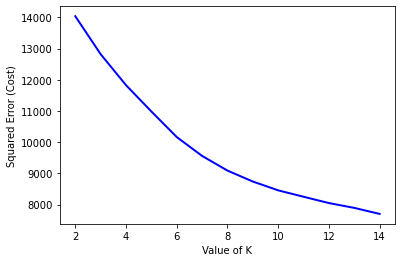

In [35]:
cost =[]
for i in range(2, 15):
    km = KMeans(n_clusters=i, n_init=10, max_iter=500, tol=1e-8).fit(x_train)
    cost.append(km.inertia_)    
 
plt.plot(range(2, 15), cost, color ='b', linewidth ='2')
plt.xlabel("Value of K")
plt.ylabel("Squared Error (Cost)")
plt.show()

## Plot clusters Using PCA

In [36]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(x_train)

pca_x = pca_result[:,0]
pca_y = pca_result[:,1] 

### K-means clusters

<AxesSubplot:>

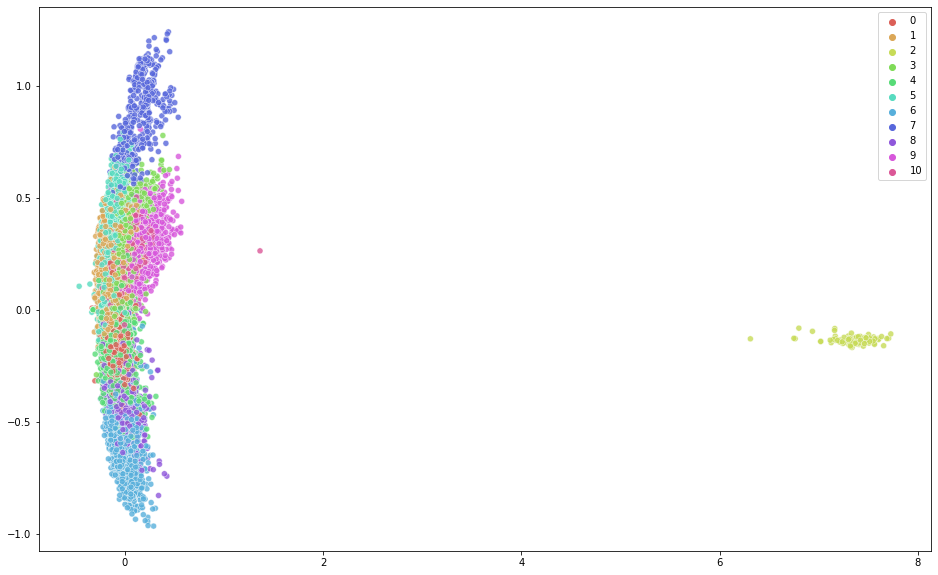

In [29]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_x, y=pca_y,
    hue=Y_predicted,
    palette=sns.color_palette("hls", 11),
    legend="full",
    alpha=0.8
)

### Documents true classes

<AxesSubplot:>

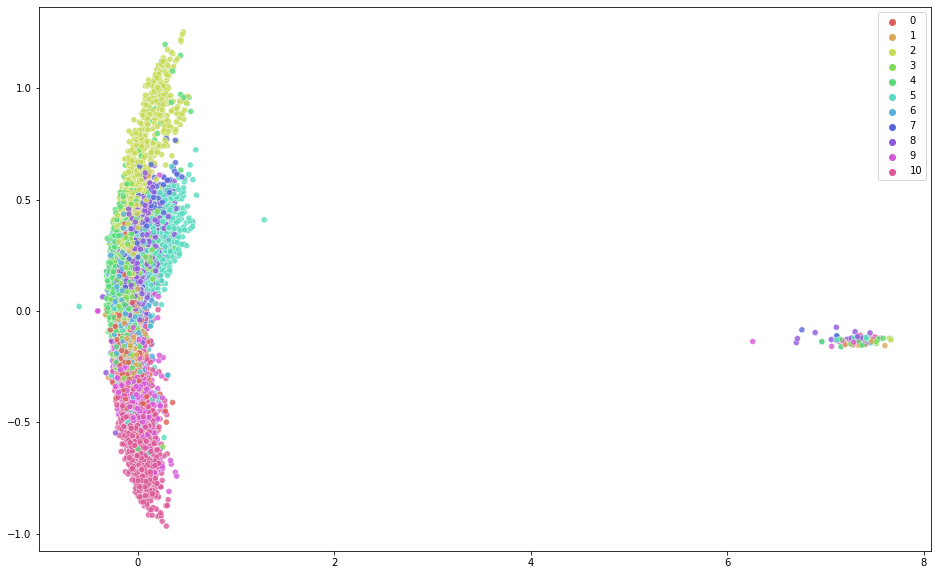

In [37]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_x, y=pca_y,
    hue=y_test,
    palette=sns.color_palette("hls",11),
    legend="full",
    alpha=0.8
)

## 3D PCA plot

In [38]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(x_train)

pca_x = pca_result[:,0]
pca_y = pca_result[:,1]
pca_z = pca_result[:,2]

### K-means clusters

/var/folders/jl/n26nkxfn5fz5lng2zqgww5pr0000gn/T/ipykernel_28203/2653611556.py:1: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')


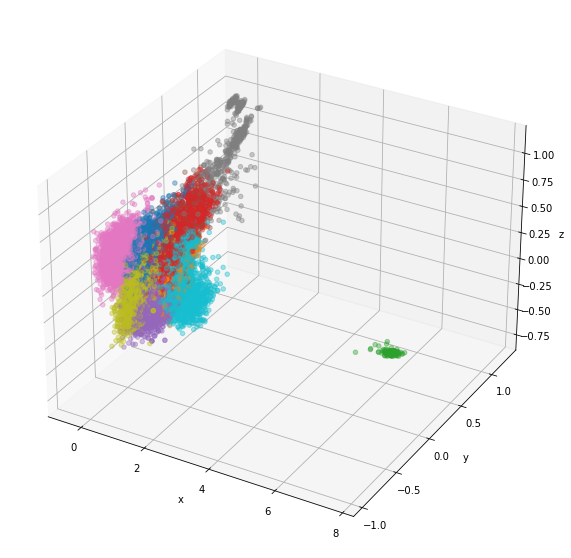

In [32]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_x, 
    ys=pca_y, 
    zs=pca_z, 
    c=Y_predicted, 
    cmap='tab10',
    alpha=0.4
)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

### Documents true classes

/var/folders/jl/n26nkxfn5fz5lng2zqgww5pr0000gn/T/ipykernel_5317/166104690.py:1: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')


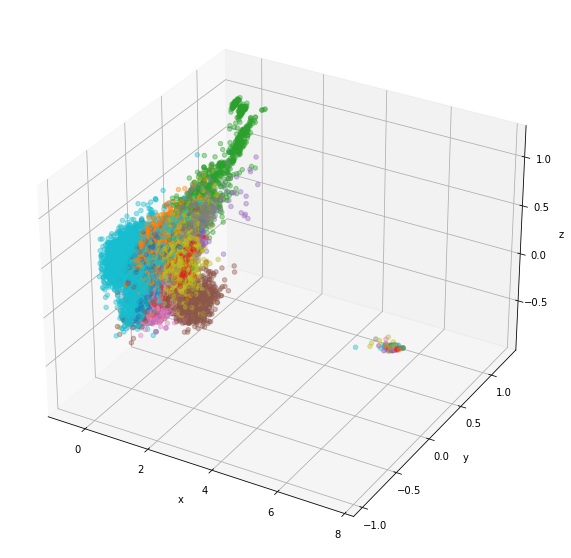

In [39]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_x, 
    ys=pca_y, 
    zs=pca_z, 
    c=y_test, 
    cmap='tab10',
    alpha=0.4
)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

## Plot clusters using TSNE

In [40]:
tsne = TSNE(n_components=2, verbose=1, perplexity=35, n_iter=1000, learning_rate=10)
tsne_results = tsne.fit_transform(x_train)

/Users/nonaghazizadeh/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 14876 samples in 0.001s...
[t-SNE] Computed neighbors for 14876 samples in 5.106s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14876
[t-SNE] Computed conditional probabilities for sample 2000 / 14876
[t-SNE] Computed conditional probabilities for sample 3000 / 14876
[t-SNE] Computed conditional probabilities for sample 4000 / 14876
[t-SNE] Computed conditional probabilities for sample 5000 / 14876
[t-SNE] Computed conditional probabilities for sample 6000 / 14876
[t-SNE] Computed conditional probabilities for sample 7000 / 14876
[t-SNE] Computed conditional probabilities for sample 8000 / 14876
[t-SNE] Computed conditional probabilities for sample 9000 / 14876
[t-SNE] Computed conditional probabilities for sample 10000 / 14876
[t-SNE] Computed conditional probabilities for sample 11000 / 14876
[t-SNE] Computed conditional probabilities for sample 12000 / 14876
[t-SNE] Computed conditional probabilities for sa

In [41]:
tsne_x = tsne_results[:,0]
tsne_y = tsne_results[:,1]

### K-means clusters

<AxesSubplot:>

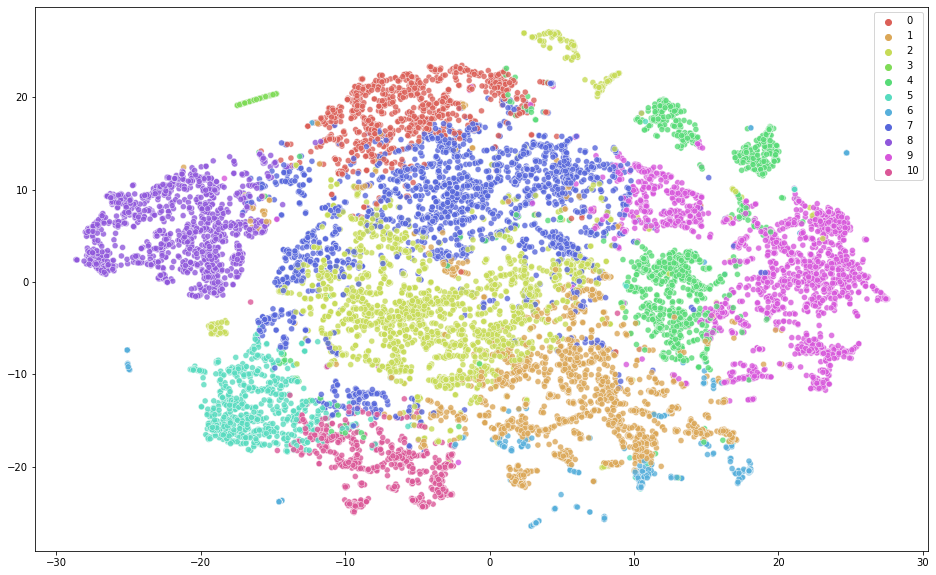

In [42]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_x, y=tsne_y,
    hue=y_pred,
    palette=sns.color_palette("hls", 11),
    legend="full",
    alpha=0.8
)

### Documents true classes

<AxesSubplot:>

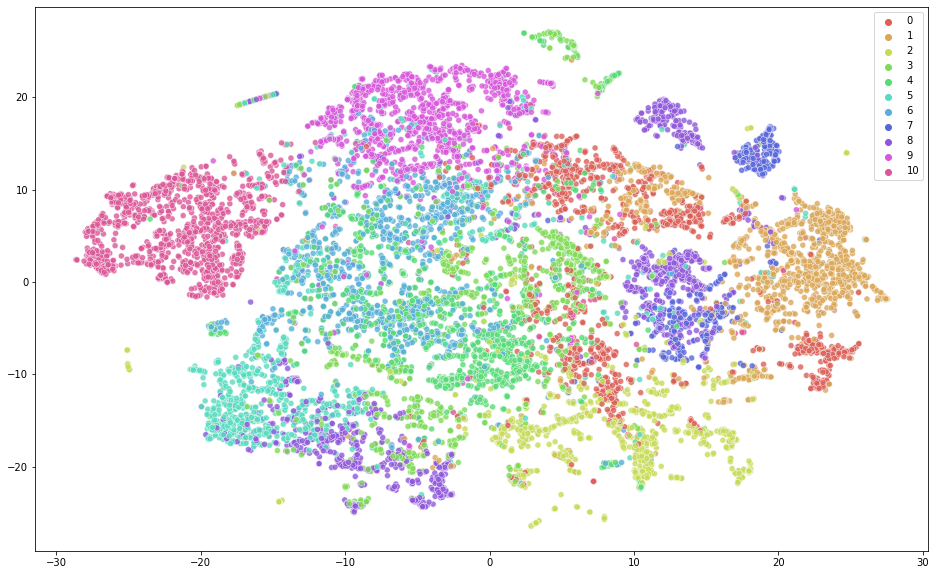

In [43]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_x, y=tsne_y,
    hue=y_test,
    palette=sns.color_palette("hls", 11),
    legend="full",
    alpha=0.8
)

## 3D TSNE plot

In [44]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=1000, learning_rate=10)
tsne_results = tsne.fit_transform(x_train)

tsne_x = tsne_results[:,0]
tsne_y = tsne_results[:,1]
tsne_z = tsne_results[:,2]

/Users/nonaghazizadeh/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 14876 samples in 0.001s...
[t-SNE] Computed neighbors for 14876 samples in 4.908s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14876
[t-SNE] Computed conditional probabilities for sample 2000 / 14876
[t-SNE] Computed conditional probabilities for sample 3000 / 14876
[t-SNE] Computed conditional probabilities for sample 4000 / 14876
[t-SNE] Computed conditional probabilities for sample 5000 / 14876
[t-SNE] Computed conditional probabilities for sample 6000 / 14876
[t-SNE] Computed conditional probabilities for sample 7000 / 14876
[t-SNE] Computed conditional probabilities for sample 8000 / 14876
[t-SNE] Computed conditional probabilities for sample 9000 / 14876
[t-SNE] Computed conditional probabilities for sample 10000 / 14876
[t-SNE] Computed conditional probabilities for sample 11000 / 14876
[t-SNE] Computed conditional probabilities for sample 12000 / 14876
[t-SNE] Computed conditional probabilities for sa

### K-means clusters

/var/folders/jl/n26nkxfn5fz5lng2zqgww5pr0000gn/T/ipykernel_5317/4046767542.py:1: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')


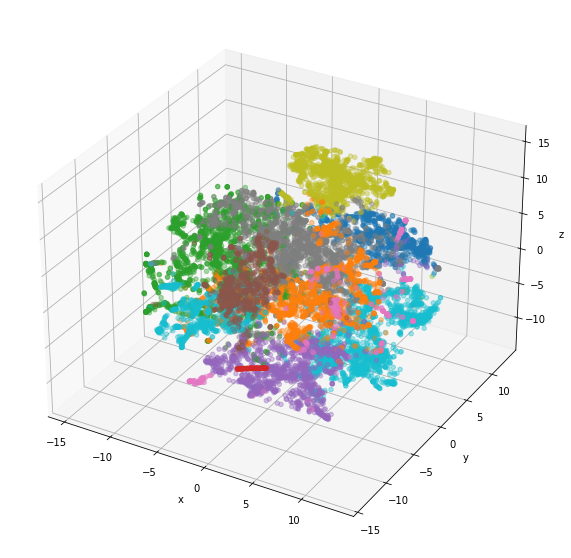

In [45]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=tsne_x, 
    ys=tsne_y, 
    zs=tsne_z, 
    c=y_pred, 
    cmap='tab10',
    alpha=0.4
)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

### Documents true classes

/var/folders/jl/n26nkxfn5fz5lng2zqgww5pr0000gn/T/ipykernel_5317/3884990833.py:1: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')


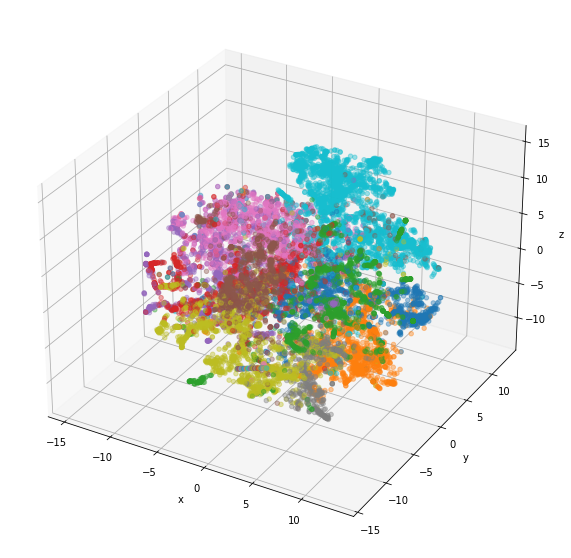

In [46]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=tsne_x, 
    ys=tsne_y, 
    zs=tsne_z, 
    c=y_test, 
    cmap='tab10',
    alpha=0.4
)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()